# Crane optimization
Here is some text explaining the problem at hand.

Also necessary optimization theory from a high level.

And maybe a figure.

And here is some math:
$$
e^{i \pi} + 1 = 0
$$

In [2]:
# Enable interactive plot
%matplotlib notebook
# %matplotlib inline

In [3]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import animation
import casadi as cs
plt.style.use('seaborn-pastel')

In [4]:
r = cs.SX.sym('r')
theta = cs.SX.sym('theta')
r_dot = cs.SX.sym('r_dot')
theta_dot = cs.SX.sym('theta_dot')
x = cs.vertcat(r, theta, r_dot, theta_dot)

F = cs.SX.sym('F')
tau = cs.SX.sym('tau')
u = cs.vertcat(F, tau)

m_1 = 1.0
m_2 = 1.0
l = 1.0
g = 9.81

M_inv = cs.SX(2,2)
M_inv[0,0] = m_2 * l**2
M_inv[0,1] = - m_2 * l * cs.cos(theta)
M_inv[1,0] = - m_2 * l * cs.cos(theta)
M_inv[1,1] = m_1 + m_2
M_inv = M_inv / ((m_1 + m_2) * m_2 * l**2 - m_2**2 * l**2 * cs.cos(theta)**2)

h = cs.SX(2,1)
h[0,0] = -m_2 * l * theta_dot**2 * cs.sin(theta)
h[1,0] = m_2 * l * g * cs.sin(theta)

x_dot = cs.vertcat(x[2:], cs.mtimes(M_inv, (u - h)))
f = cs.Function('f', [x, u], [x_dot])



In [5]:
def integrate_RK4(x_k, u_k, f, dt):
    k1 = f(x_k, u_k)
    k2 = f(x_k + dt*k1/2.0, u_k)
    k3 = f(x_k + dt*k2/2.0, u_k)
    k4 = f(x_k + dt*k3, u_k)
    return np.array(x_k + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)).squeeze()

In [6]:
N = 1000
dt = 0.01
T = N * dt
x_0 = np.array([0.0, 0.4, 0.0, 0.0])

x_sim = np.zeros((N+1,4))
u_sim = np.zeros((N,2))
x_sim[0,:] = x_0
for k in range(N):
    x_sim[k+1,:] = integrate_RK4(x_sim[k], u_sim[k], f, dt)

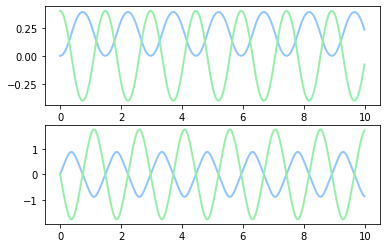

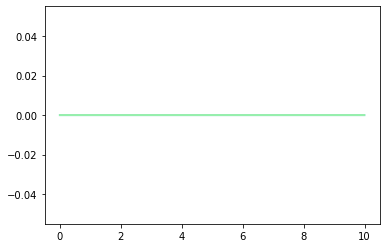

In [7]:
t = np.array([dt*i for i in range(N)])

fig, axs = plt.subplots(2)

axs[0].plot(t, x_sim[:N,0])
axs[0].plot(t, x_sim[:N,1])

axs[1].plot(t, x_sim[:N,2])
axs[1].plot(t, x_sim[:N,3])

plt.figure()
plt.step(t, u_sim, where='post')

plt.show()

In [63]:
from IPython.display import HTML

mpl.rcParams['lines.linewidth'] = 2

skips = 8
frames = int(N / skips)
delay = skips*dt*1e3

rect_height = 0.2
beam_height = 0.075

fig, ax = plt.subplots()

line_1, = ax.plot([-1.2,1.2], [0,0], 'k--', lw=1.0)
rect_1 = ax.add_patch(Rectangle((0 - 1, 0 - 0.5*beam_height), 2, beam_height, facecolor='darkslategray', edgecolor='k', lw=2))
rect_2 = ax.add_patch(Rectangle((x_sim[0,0] - 0.2, 0.0 - 0.5*rect_height), 0.4, rect_height, facecolor='teal', edgecolor='k', lw=2))

x_pendulum = x_sim[0,0] + l * np.sin(x_sim[0,1])
y_pendulum = -l * np.cos(x_sim[0,1])
# line_2, = ax.plot([x_sim[0,0], x_pendulum], [0, y_pendulum], '-o', c='k', lw=3, ms=8, mec='k', mfc='crimson', mew=2)
line_2, = ax.plot([x_sim[0,0], x_pendulum], [0, y_pendulum], '-o', c='k', lw=3, ms=6)
point_1 = ax.scatter(x_pendulum, y_pendulum, s=500, facecolors='darkorange', edgecolors='k', lw=2)

plt.axis('equal')
plt.xlim([-1, 1])
plt.ylim([-1.5, 0.5])

def animate(i):
    rect_2.set_xy([x_sim[skips*i,0] - 0.2, 0.0 - 0.5*rect_height])
    
    x_pendulum = x_sim[skips*i,0] + l * np.sin(x_sim[skips*i,1])
    y_pendulum = -l * np.cos(x_sim[skips*i,1])
    
    point_1.set_offsets([x_pendulum, y_pendulum])
    line_2.set_data([x_sim[skips*i,0], x_pendulum], [0, y_pendulum])
    
    return line_1, line_2, point_1, rect_1, rect_2

anim = animation.FuncAnimation(fig, animate, frames=frames, interval=delay, blit=True)

<IPython.core.display.Javascript object>

In [64]:
HTML(anim.to_jshtml())